In [1]:
import numpy as np
from mrashpen.models.plr_ash import PenalizedMrASH as PenMrASH
from mrashpen.models.normal_means_ash import NormalMeansASH

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

In [2]:
def _ash_data(n = 20000, p = 1000, p_causal = 5, pve = 0.5, rho = 0.0, k = 6): 

    def sd_from_pve (X, b, pve):
        return np.sqrt(np.var(np.dot(X, b)) * (1 - pve) / pve)

    ''' 
    ASH prior
    '''
    wk = np.zeros(k) + 1e-4
    wk[1:(k-1)] = np.repeat(1/(k-1), (k - 2)) 
    wk[k-1] = 1 - np.sum(wk)
    sk = np.arange(k)
    ''' 
    Equicorr predictors
    X is sampled from a multivariate normal, with covariance matrix V.
    V has unit diagonal entries and constant off-diagonal entries rho.
    '''
    iidX    = np.random.normal(size = n * p).reshape(n, p)
    comR    = np.random.normal(size = n).reshape(n, 1)
    X       = comR * np.sqrt(rho) + iidX * np.sqrt(1 - rho)
    bidx    = np.random.choice(p, p_causal, replace = False)
    b       = np.zeros(p)
    b[bidx] = np.random.normal(size = p_causal)
    sigma   = sd_from_pve(X, b, pve)
    y       = np.dot(X, b) + sigma * np.random.normal(size = n)
    return X, y, b, sigma, wk, sk

In [3]:
X, y, b, strue, wk, sk = _ash_data()
n, p = X.shape
s2true = strue * strue
dj = np.sum(np.square(X), axis = 0)

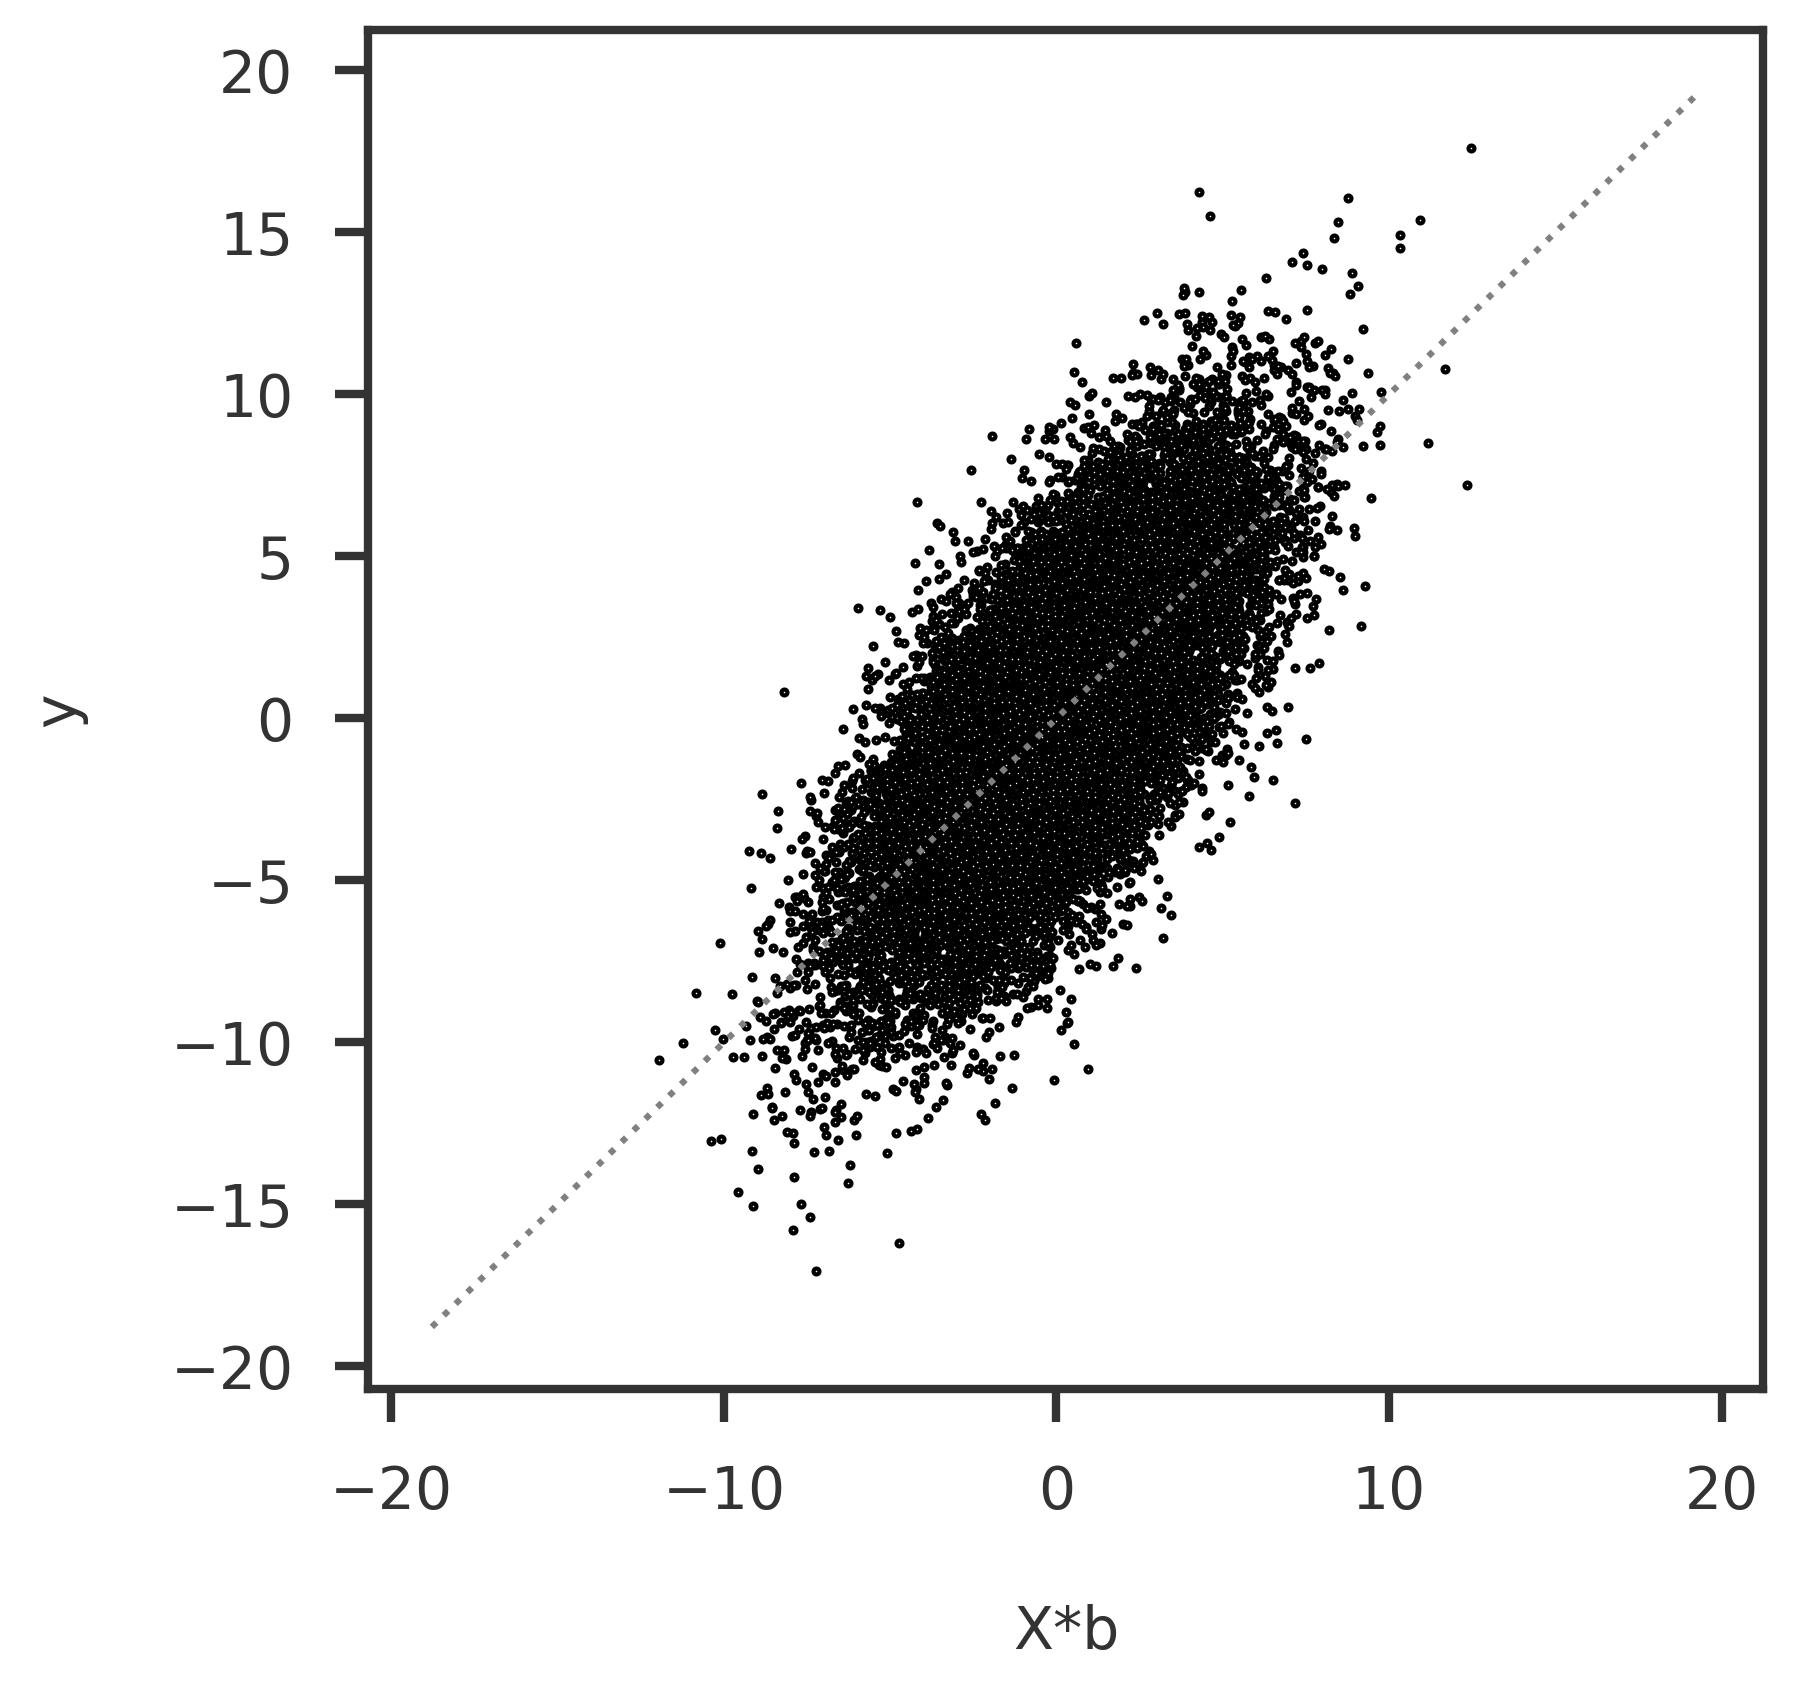

In [4]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(np.dot(X, b), y, edgecolor = 'black', facecolor='white', label="ytest", s = 2)
ax1.set_xlabel("X*b")
ax1.set_ylabel("y")
mpl_utils.plot_diag(ax1)
plt.show()

In [5]:
def nm_posterior(y, s, wk, sk):
    n = y.shape[0]
    k = wk.shape[0]
    if not isinstance(s, np.ndarray):
        s = np.repeat(s, n)
    s2  = np.square(s).reshape(n, 1)
    sk2 = np.square(sk).reshape(1, k)
    y2  = np.square(y).reshape(n, 1)
    v2jk  = s2 + sk2 
    mujk  = y.reshape(n, 1) * sk2 / v2jk
    varjk = s2 * sk2 / v2jk

    logLjk = -0.5 * (np.log(v2jk) + y2 / v2jk)
    phijk  = np.exp(logLjk - np.max(logLjk, axis = 1).reshape(-1, 1)) * wk
    phijk /= np.sum(phijk, axis = 1).reshape(n, 1)
    return phijk, mujk, varjk

In [6]:
# # phijk, mujk, varjk = nm_posterior(bjtilde, sj, wk, sk)
# nmash = NormalMeansASH(bjtilde, sj, wk, sk)
# phijk, mujk, varjk = nmash.posterior()

In [7]:
b[np.where(b!=0)]

array([-0.44701989, -2.19913945,  1.04683463, -1.20485793, -1.0079761 ])

In [48]:
def mrash_elbo_old(X, y, bjtilde, s2, wk, sk, dj):
    n, p = X.shape
    k = wk.shape[0]
    sj = np.sqrt(s2 / dj)
    nmash = NormalMeansASH(bjtilde, sj, wk, sk, debug = False)
    phijk, mujk, varjk = nmash.posterior()
    bbar = np.sum(phijk * mujk, axis = 1)
    t1 = - 0.5 * n * np.log(2 * np.pi * s2)
    t2 = - 0.5 * np.sum(np.square(y - np.dot(X, bbar))) / s2
    t3 = - 0.5 * np.sum(dj * np.sum(phijk * (np.square(mujk) + varjk) \
                                    - np.square(bbar).reshape(-1, 1), axis = 1)) / s2
    phijk[phijk == 0] += 1e-8
    t4 = - np.sum(phijk * np.log(phijk / wk))
    t5 = 0.5 * np.sum(phijk[:, 1:] * (1 + np.log(varjk[:, 1:] / (s2 * np.square(sk)[1:])) \
            - (varjk + np.square(mujk))[:, 1:] / (s2 * np.square(sk)[1:])))
    return np.array([t1, t2, t3, t4, t5, t2 + t3])

def mrash_elbo(X, y, bjtilde, s2, wk, sk, dj):
    n, p = X.shape
    k = wk.shape[0]
    sj = np.sqrt(s2 / dj)
    nmash = NormalMeansASH(bjtilde, sj, wk, sk, debug = False)
    phijk, mujk, varjk = nmash.posterior()
    bbar = np.sum(phijk * mujk, axis = 1)
    t1 = - 0.5 * n * np.log(2 * np.pi * s2)
    t2 = - 0.5 * np.sum(np.square(y - np.dot(X, bbar))) / s2
    t3 = - 0.5 * np.sum(dj * np.sum(phijk * (np.square(mujk) + varjk) \
                                    - np.square(bbar).reshape(-1, 1), axis = 1)) / s2
    phijk[phijk == 0] += 1e-8
    t4 = - np.sum(phijk * np.log(phijk / wk))
    t5 = 0.5 * np.sum(phijk[:, 1:] * (1 + np.log(varjk[:, 1:] / s2)) \
            - (varjk + np.square(mujk))[:, 1:] / s2)
    return np.array([t1, t2, t3, t4, t5, t1 + t2 + t3 + t4 + t5])

elbo_component = ['t1', 't2', 't3', 't4', 't5', 'total']

In [49]:
rjbar = y.reshape(-1, 1) - (np.dot(X, b).reshape(-1, 1) - (X * b)) # shape N x P
bjtilde = np.einsum('ij,ij->j', X, rjbar) / dj

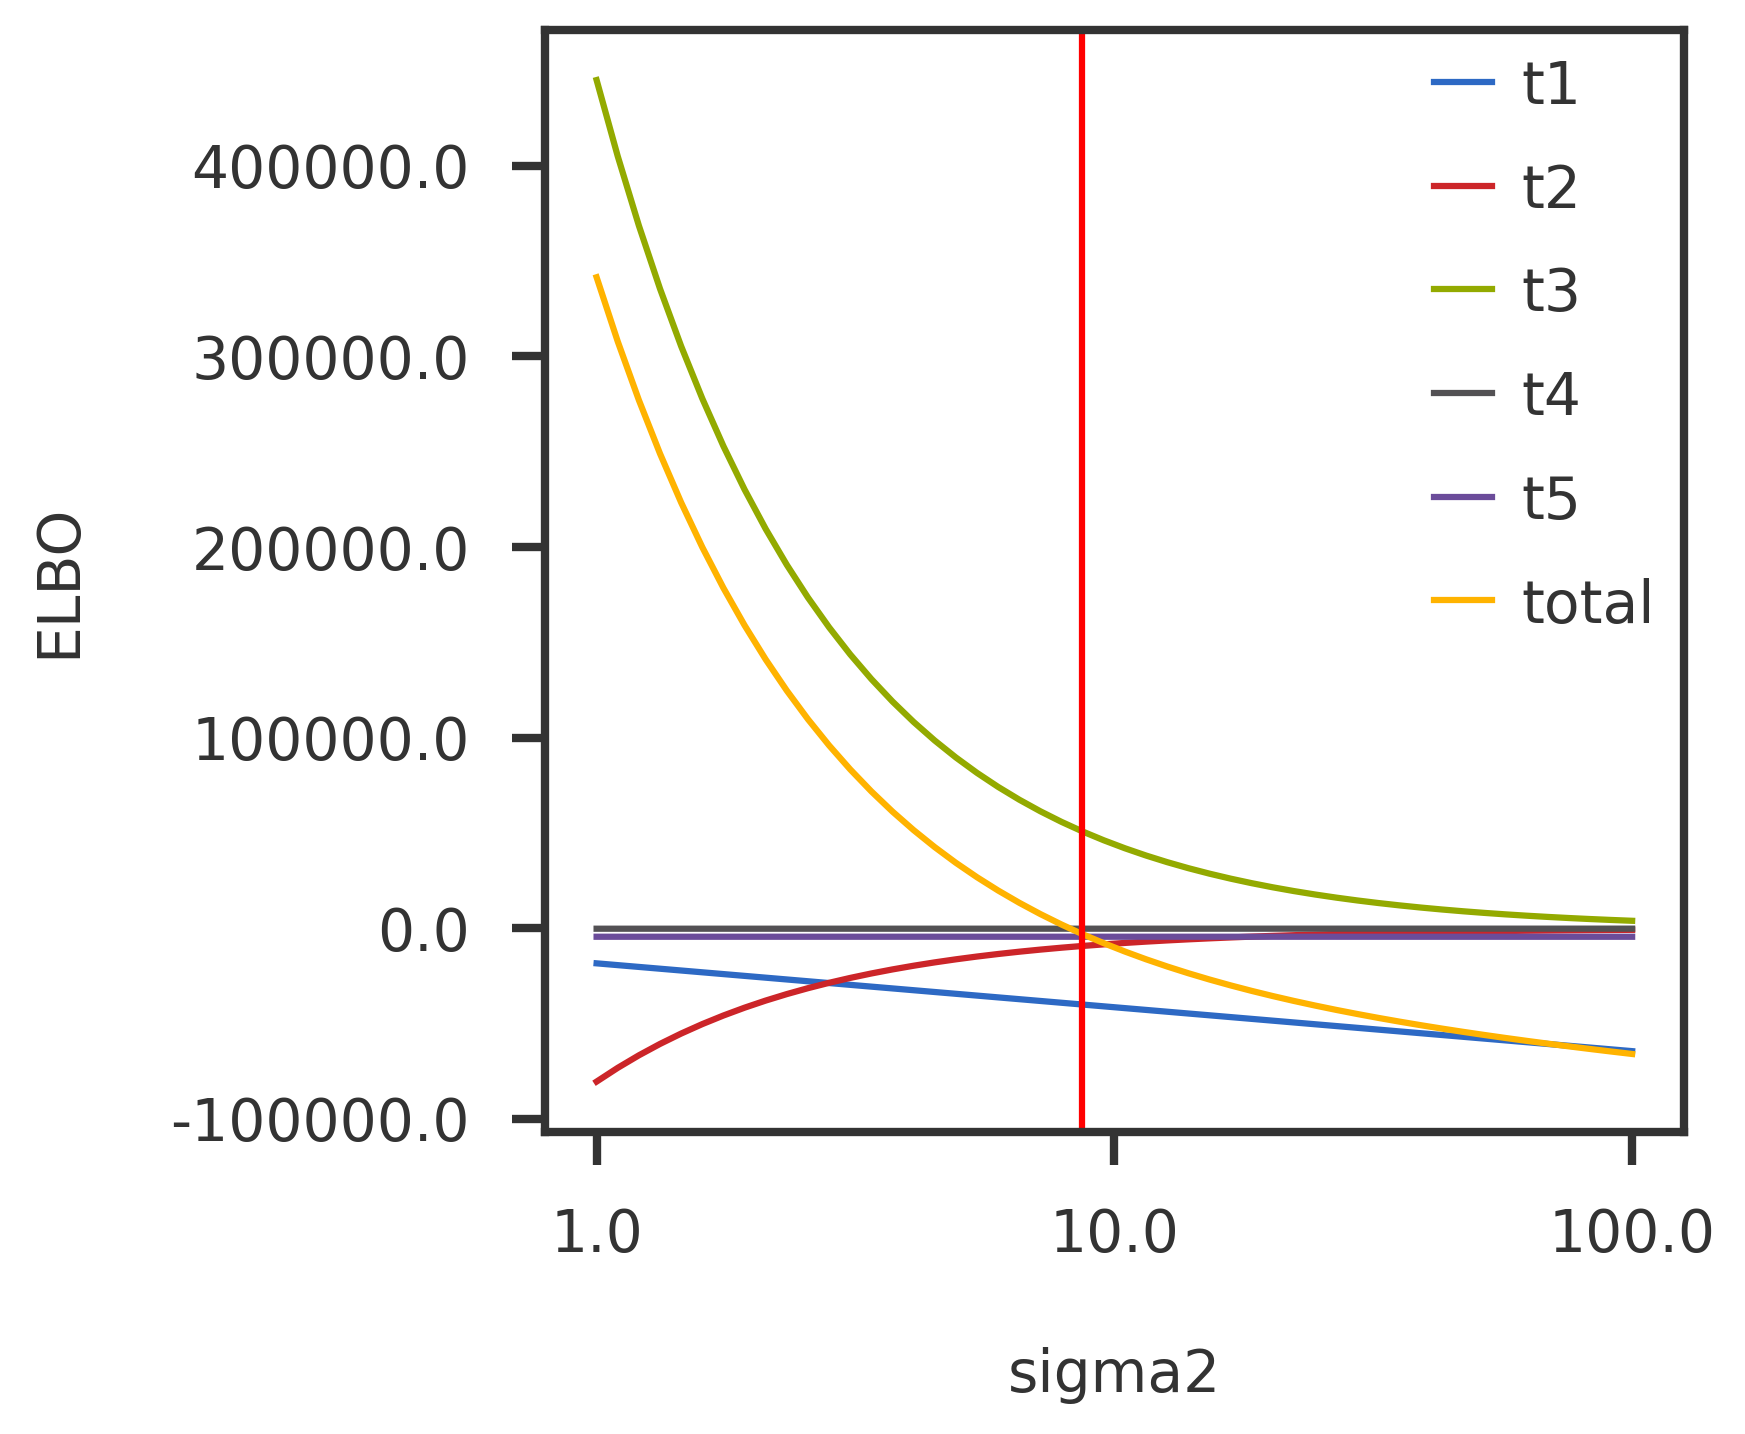

In [50]:
sigma2seq = np.logspace(0, 2, 50)
elboseq   = np.zeros((50, 6))

n, p = X.shape
for i, sigma2 in enumerate(sigma2seq):
    elboseq[i, :] = mrash_elbo(X, y, bjtilde, sigma2, wk, sk, dj)

fig = plt.figure(figsize = (6, 5))
ax1 = fig.add_subplot(111)

xscale = 'log10'
yscale = 'linear'
for i in range(elboseq.shape[1]):
    ax1.plot(mpl_utils.scale_array(sigma2seq, xscale), 
             mpl_utils.scale_array(elboseq[:, i], yscale), label = elbo_component[i])

for ax in [ax1]:
    mpl_utils.set_xticks(ax, scale = xscale, spacing = xscale)
    mpl_utils.set_yticks(ax, scale = yscale, spacing = yscale)
    ax.axvline(x = mpl_utils.scale_array(np.array([s2true]), xscale)[0], color = 'red')
    ax.set_xlabel("sigma2")
ax1.set_ylabel("ELBO")
ax1.legend()
plt.tight_layout()
plt.show()